<center>

Programação Paralela e Distribuída
===
---

# Trabalho 2 
    
### Multiplicação de matrizes em paralelo
    
### Paralelização e a biblioteca OpenMP

</center>

**Alunos**

Cleidson Francisco de Almeida 761766

Wesley Nogueira Galvão 757665

Março, 2021

# Escalabilidade da multiplicação de matrizes 

Usando o mecanismo de paralelização de aplicações com OpenMP, investigar a escalabilidade do programa de multiplicação de matrizes. Para tanto, deve-se ajustar o código para a paralização de apenas um dos loops do cálculo de cada vez. 

```c
for (i=0; i < nlin; i++)                              // loop externo
   for (j=0; j < ncol; j++) {.                        // loop intermediário
      c[i][j] = 0;
      // problema: somas parciais de c[i][j]....
      for (k=0; k < dim; k++).                        // loop interno
         c[i][j]= c[i][j] + a[i][k]*b[k][j];
   }

```
Para cada forma de paralelização, investigar os tempos envolvidos e como muda o resultado da aplicação quando são utilizados diferentes números de threads (1, 2, 4, 8, 16, 32, 64, 128).

Por fim, deve-se submeter a esta tarefa um arquivo com o código, os resultados dos testes e comentários sobre as estratégias e os ganhos de desempenho obtidos.

Como medir os tempos de execução? Vejam os exemplos (limits/consumo.c), ou usem to utilitário time (1) na ativação do programa.

O trabalho pode ser feito em duplas.

```c
-----------------------------
/*
** PPD / DC/UFSCar - Helio
** Programa : multiplicacao de matrizes
** Objetivo: paralelizacao om OpenMP
*/

#include math.h 
#include stdlib.h 
#include string.h 
#include stdio.h
#include unistd.h
#include time.h

float *A, *B, *C;

int
main(int argc, char *argv[])
{
  int lin_a,col_a,lin_b,col_b,lin_c,col_c;
  int i,j,k;

  printf("Linhas A: ");   scanf("%d",&lin_a);
  printf("Colunas A / Linhas B: "); scanf("%d",&col_a);
  lin_b=col_a;
  printf("Colunas B: ");  scanf("%d",&col_b);
  printf("\n");
  lin_c=lin_a;
  col_c=col_b;

  // Alocacao dinamica das matrizes, com linhas em sequencia 
  A = (float *)malloc(lin_a*col_a*sizeof(float));
  B = (float *)malloc(lin_b*col_b*sizeof(float));
  C = (float *)malloc(lin_c*col_c*sizeof(float));

  // Atribucao de valores iniciais as matrizes 
  srandom(time(NULL));

  for(i=0; i < lin_a * col_a; i++) 
    A[i]=(float)rand() / (float)RAND_MAX; 

  for(i=0; i < lin_b * col_b; i++) 
    B[i]=(float)rand() / (float)RAND_MAX; 

  // calculo da multiplicacao
 
  // Qual/quais loop(s) paralelizar? Vale a pena paralelizar todos?
  // Qual é o efeito de fazer um parallel for em cada um dos fors abaixo?
  // É necessários sincronizar alguma operação, garantindo exclusão mútua?
 
  for(i=0; i < lin_c; i++) 

    for(j=0; j < col_c; j++) {

      C[i*col_c+j]=0;
 
      for(k=0; k < col_a; k++) 
        C[i*col_c+j] = C[i*col_c+j] + A[i*col_a+k] * B[k*col_b+j];
    }

  return(0);
}

```

# Implementação Paralela - OpenMP


In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


## Informações do sistema

Para este experimento, foi usada uma instância de máquina na nuvem fornecida pelo [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb). Especificamente, a máquina foi utilizada sob uma implementação do Jupyter Notebook para documentação e execução dinâmica dos códigos.

Seguem as informações de Sistema Operacional, CPU e memória RAM. 



In [ ]:
# Operational System Info
! lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


Embora apresente 2 núcleos, notou-se nos testes que a alocação de CPU é dinâmica, de acordo com a necessidade do usuário. 

In [ ]:
# CPU Info
! lscpu | grep  'Model name\|^CPU(s)\|L3 cache\|Architecture' 

Architecture:        x86_64
CPU(s):              2
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
L3 cache:            46080K


In [ ]:
# RAM Memory info
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        534M         10G        984K        1.9G         11G
Swap:            0B          0B          0B


## Implementação

A  região de parelização foi definida no `for()` mais externo. O uso de `schedule(dynamic)` se dá como estratégia a evitar que threads fiquem ociosas assim que terminarem suas tarefas. O uso de `firstprivate(A,B)` mantém os valores atribuídos às matrizes iniciais. Por fim, o uso de `private(i,j,k)` torna os iteradores privados dentro do escopo da thread. 

In [ ]:
%%%%writefile matriz_multi_paralelo.c

/*
** PPD / DC/UFSCar - Helio
** Programa : multiplicacao de matrizes
** Objetivo: paralelizacao em OpenMP
** Alunos :
 	Cleidson Francisco de Almeida 761766
	Wesley Nogueira Galvão 757665

**Para compilar: 
  gcc matriz_multi_paralelo.c -o mmp -lm -fopenmp
** Para executar:
  ./mmp [num_linhas_A] [num_colunas_A] [num_colunas_B] [num_execucoes]  >> result.csv
*/

#include <math.h> 
#include <stdlib.h>
#include <string.h>
#include <stdio.h>
#include <unistd.h>
#include <sys/types.h>
#include <sys/stat.h>
#include <time.h>
#include <sys/time.h>
#include <omp.h>


float *A, *B, *C;

void multiplicacaoMatrizes(int lin_a, int col_a, int col_b, int num_threads){

    int lin_b = col_a; 
    int lin_c = lin_a;
    int col_c = col_b;
    int i,j,k;
    
    C = (float *)malloc(lin_c*col_c*sizeof(float));
    omp_set_num_threads(num_threads);

    #pragma omp parallel for schedule(dynamic) firstprivate(A,B) private(i,j,k)
    for(i=0; i < lin_c; i++)
        for(j=0; j < col_c; j++) {

        C[i*col_c+j]=0;
    
        for(k=0; k < col_a; k++) 
            C[i*col_c+j] = C[i*col_c+j] + A[i*col_a+k] * B[k*col_b+j];
        }
}

int main(int argc, char *argv[]){
  
    int lin_a,col_a,lin_b,col_b,lin_c,col_c;
    int i,j,k;


    struct timeval begin, end;


    // Lê o num de linhas para A 
    lin_a = atoi(argv[1]);
    // Lê o num de colunas para A 
    col_a = atoi(argv[2]);
    lin_b=col_a;
    // Lê o num de colunas para B  
    col_b = atoi(argv[3]);

    lin_c=lin_a;
    col_c=col_b;

    int num_execs = atoi(argv[4]);

    // Alocacao dinamica das matrizes, com linhas em sequencia 
    A = (float *)malloc(lin_a*col_a*sizeof(float));
    B = (float *)malloc(lin_b*col_b*sizeof(float));
    //C = (float *)malloc(lin_c*col_c*sizeof(float));

    // Atribucao de valores iniciais as matrizes 
    srandom(time(NULL));


    for(i=0; i < lin_a * col_a; i++) 
        A[i]=(float)rand() / (float)RAND_MAX; 

    for(i=0; i < lin_b * col_b; i++) 
        B[i]=(float)rand() / (float)RAND_MAX;

    // calculo da multiplicacao
    
    // Qual/quais loop(s) paralelizar? Vale a pena paralelizar todos?
    // Qual é o efeito de fazer um parallel for em cada um dos fors abaixo?
    // É necessários sincronizar alguma operação, garantindo exclusão mútua?

    
    //printf("Quantidade de iteracoes por thread (para media): ");   
    
    int num_threads;
    int expoente = 0;
    printf("Exec_id,num_threads,elapsed_time\n");
    while(expoente < 8 ){

        num_threads = pow(2, expoente);        

        for(int exec = 0; exec < num_execs; exec++){
            // Start measuring time
            gettimeofday(&begin, 0);

            multiplicacaoMatrizes(lin_a, col_a, col_b, num_threads);

            // Stop measuring time and calculate the elapsed time
            gettimeofday(&end, 0);
            long seconds = end.tv_sec - begin.tv_sec;
            long microseconds = end.tv_usec - begin.tv_usec;
            double elapsed = seconds + microseconds*1e-6;
            // Imprime o ID da execução, número de threads usadas e o tempo de execução
            printf("%d,%d,%.6f\n", exec+1, num_threads, elapsed);

        }
        expoente++;
    } 
    
    // desaloca as matrizes
        free(A);
        free(B);
        free(C);

    return(0);
}

Overwriting matriz_multi_paralelo.c


# Avaliação

**Os dados analisados aqui são da última execução deste notebook. **

Neste experimento, foi considerada a multiplicação entre matrizes quadradas de dimensão 500 x 500. Para tanto, variou-se o número de threads em potência de 2, sendo 1, 2, 4, 8, 16, 32, 64 e 128. Para cada variação, o código foi executado 5 vezes, a fim de capturar o tempo decorrido em cada execução e calcular a média aritmética. 

O comando para compilação é : 

`gcc matriz_multi_paralelo.c -o mmp -lm -fopenmp`

Para execução, fez-se : 

`./mmp [num_linhas_A] [num_colunas_A] [num_colunas_B] [num_execucoes]  >> result.csv`

O resultado da execução, contento as informações de ID da execução, número de threads e tempo de execução, foi exportado para um arquivo CSV. Os dados serão avaliados em seguida. 


In [ ]:
# Compilação e execução do código
! gcc matriz_multi_paralelo.c -o mmp -lm -fopenmp && ./mmp 500 500 500 5  >> result.csv

A tabela abaixo corresponde ao resultado. 

In [ ]:
# Importa como dataframe os resultados do arquivo result.csv
result = pd.read_csv('/content/result.csv')
result.head(22)

,Exec_id,num_threads,elapsed_time
0,1,1,0.910452
1,2,1,0.854464
2,3,1,0.857531
3,4,1,0.860646
4,5,1,0.846051
5,1,2,0.771601
6,2,2,0.742827
7,3,2,0.727218
8,4,2,0.737313
9,5,2,0.731894


Pelo gráfico boxplot, vê que que o maior tempo de execução ocorreu com uma thread, e o menor com duas. 

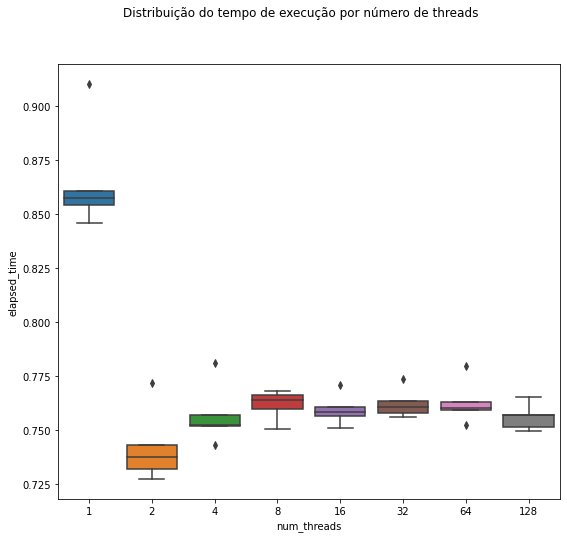

In [ ]:
# Plota boxplot por número de threads
plt.figure(figsize=(9,8))
plt.suptitle('Distribuição do tempo de execução por número de threads')

sns.boxplot(x='num_threads', y='elapsed_time', data=result)

## Speedup

Segundo o artigo no [Wikipedia](https://pt.wikipedia.org/wiki/Lei_de_Amdahl#:~:text=O%20speedup%20final%20%C3%A9%20calculado,a%20fun%C3%A7%C3%A3o%20da%20f%C3%B3rmula%20acima.&text=ou%20um%20pouco%20menos%20que,do%20tempo%20de%20execu%C3%A7%C3%A3o%20original), o speedup é dado pela razão entre o tempo gasto pra executar a tarefa com um único processador e o tempo gasto com N processadores. Isto é, é a medida do ganho em tempo.

$$S = \frac{T(1)}{T(N)}$$

In [ ]:
# Calcula o sumário das estatísticas
summary = result.groupby('num_threads')['elapsed_time'].describe()
# Reseta o index do DataFrame
summary.reset_index(inplace = True)
# Remove algumas colunas não interessantes para esta avaliação
summary.drop(['count','25%','75%'], axis = 1, inplace = True)
# renomeia as colunas
summary.rename(columns={'50%':'time_median', 'mean':'time_avg'}, inplace = True)
# Calcula o speedup
summary['speedup'] = summary.time_avg[0]/summary.time_avg
# Exibe o sumário
summary

,num_threads,time_avg,std,min,time_median,max,speedup
0,1,0.865829,0.025531,0.846051,0.857531,0.910452,1.000000
1,2,0.742171,0.017460,0.727218,0.737313,0.771601,1.166617
2,4,0.756950,0.014281,0.743138,0.752149,0.780926,1.143839
3,8,0.761700,0.006943,0.750627,0.763893,0.768086,1.136705
4,16,0.759398,0.007274,0.750764,0.758314,0.770658,1.140151
5,32,0.762268,0.006923,0.755824,0.760566,0.773561,1.135859
6,64,0.762798,0.010227,0.752178,0.760007,0.779704,1.135069
7,128,0.755937,0.006167,0.749324,0.756861,0.765188,1.145371


Pelos gráficos, o menor tempo médio de execução ocorreu com duas threads. Isso se vê no gráfico do speedup, que teve a maior taxa justamente com duas threads executando a tarefa. Após isso, a curva tende a se estabilizar. 

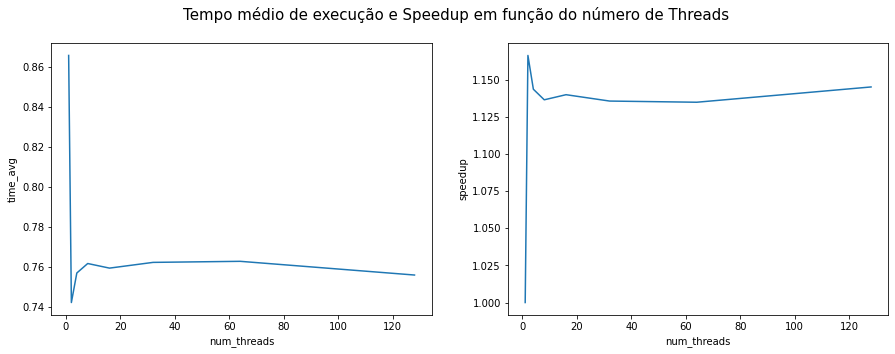

In [ ]:
# Plotagem do tempo médio de execução e Speedup em função do número de Threads
f, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True) # Configura 2 subplots 
f.suptitle('Tempo médio de execução e Speedup em função do número de Threads', fontsize=15) 

sns.lineplot(data = summary, x = "num_threads", y = "time_avg",  
             markers=True, dashes=False, ax = axes[0])
sns.lineplot(data = summary, x = "num_threads", y = "speedup",  
             markers=True, dashes=False, ax = axes[1])